In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import the data

In [2]:
#import the data from the csv file from kaggle
df_nasa = pd.read_csv('exoplanets.csv', sep=',', header=0)
# Print the shape of the dataset
print(df_nasa.shape)
# Print the first 100 rows of the dataset
df_nasa.head(100)

(9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3734868,K00805.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.053,0,1,0,0,...,-169.0,4.359,0.180,-0.180,1.024,0.280,-0.186,287.69675,38.886452,15.646
96,3832474,K00806.01,Kepler-30 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-120.0,4.556,0.014,-0.081,0.867,0.079,-0.037,285.28363,38.947281,15.403
97,8395660,K00116.03,Kepler-106 b,CONFIRMED,CANDIDATE,0.950,0,0,0,0,...,-117.0,4.406,0.090,-0.110,1.012,0.154,-0.103,300.86398,44.337551,12.882
98,3832474,K00806.02,Kepler-30 c,CONFIRMED,CANDIDATE,0.745,0,0,0,0,...,-120.0,4.556,0.014,-0.081,0.867,0.079,-0.037,285.28363,38.947281,15.403


In [3]:
#Rename columns (more meaningful names)
df_nasa = df_nasa.rename(columns={'kepid':'KepID',
'kepoi_name':'KOIName',
'kepler_name':'KeplerName',
'koi_disposition':'ExoplanetArchiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
'koi_fpflag_ss':'koi_fpflag_ss',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod_days',
'koi_period_err1':'OrbitalPeriodUpperUnc_days',
'koi_period_err2':'OrbitalPeriodLowerUnc_days',
'koi_time0bk':'TransitEpoch_BKJD',
'koi_time0bk_err1':'TransitEpochUpperUnc_BKJD',
'koi_time0bk_err2':'TransitEpochLowerUnc_BKJD',
'koi_impact':'ImpactParamete',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration_hrs',
'koi_duration_err1':'TransitDurationUpperUnc_hrs',
'koi_duration_err2':'TransitDurationLowerUnc_hrs',
'koi_depth':'TransitDepth_ppm',
'koi_depth_err1':'TransitDepthUpperUnc_ppm',
'koi_depth_err2':'TransitDepthLowerUnc_ppm',
'koi_prad':'PlanetaryRadius_Earthradii',
'koi_prad_err1':'PlanetaryRadiusUpperUnc_Earthradii',
'koi_prad_err2':'PlanetaryRadiusLowerUnc_Earthradii',
'koi_teq':'EquilibriumTemperatureK',
'koi_teq_err1':'EquilibriumTemperatureUpperUncK',
'koi_teq_err2':'EquilibriumTemperatureLowerUncK',
'koi_insol':'InsolationFlux_Earthflux',
'koi_insol_err1':'InsolationFluxUpperUnc_Earthflux',
'koi_insol_err2':'InsolationFluxLowerUnc_Earthflux',
'koi_model_snr':'TransitSignal-to-Nois',
'koi_tce_plnt_num':'TCEPlanetNumber',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'StellarEffectiveTemperatureK',
'koi_steff_err1':'StellarEffectiveTemperatureUpperUncK',
'koi_steff_err2':'StellarEffectiveTemperatureLowerUncK',
'koi_slogg':'StellarSurfaceGravity_log10(cm/s**2)',
'koi_slogg_err1':'StellarSurfaceGravityUpperUnc_log10(cm/s**2)',
'koi_slogg_err2':'StellarSurfaceGravityLowerUnc_log10(cm/s**2)',
'koi_srad':'StellarRadius_Solarradii',
'koi_srad_err1':'StellarRadiusUpperUnc_Solarradii',
'koi_srad_err2':'StellarRadiusLowerUnc_Solarradii',
'ra':'RA_decimaldegrees',
'dec':'Dec_decimaldegrees',
'koi_kepmag':'Kepler-band_mag'
})
df_nasa.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,...,StellarEffectiveTemperatureLowerUncK,StellarSurfaceGravity_log10(cm/s**2),StellarSurfaceGravityUpperUnc_log10(cm/s**2),StellarSurfaceGravityLowerUnc_log10(cm/s**2),StellarRadius_Solarradii,StellarRadiusUpperUnc_Solarradii,StellarRadiusLowerUnc_Solarradii,RA_decimaldegrees,Dec_decimaldegrees,Kepler-band_mag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Explore the data 

In [4]:
# Analysing type of data
df_nasa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   KepID                                                  9564 non-null   int64  
 1   KOIName                                                9564 non-null   object 
 2   KeplerName                                             2359 non-null   object 
 3   ExoplanetArchiveDisposition                            9564 non-null   object 
 4   DispositionUsingKeplerData                             9564 non-null   object 
 5   DispositionScore                                       8054 non-null   float64
 6   NotTransit-LikeFalsePositiveFlag                       9564 non-null   int64  
 7   koi_fpflag_ss                                          9564 non-null   int64  
 8   CentroidOffsetFalsePositiveFlag                 

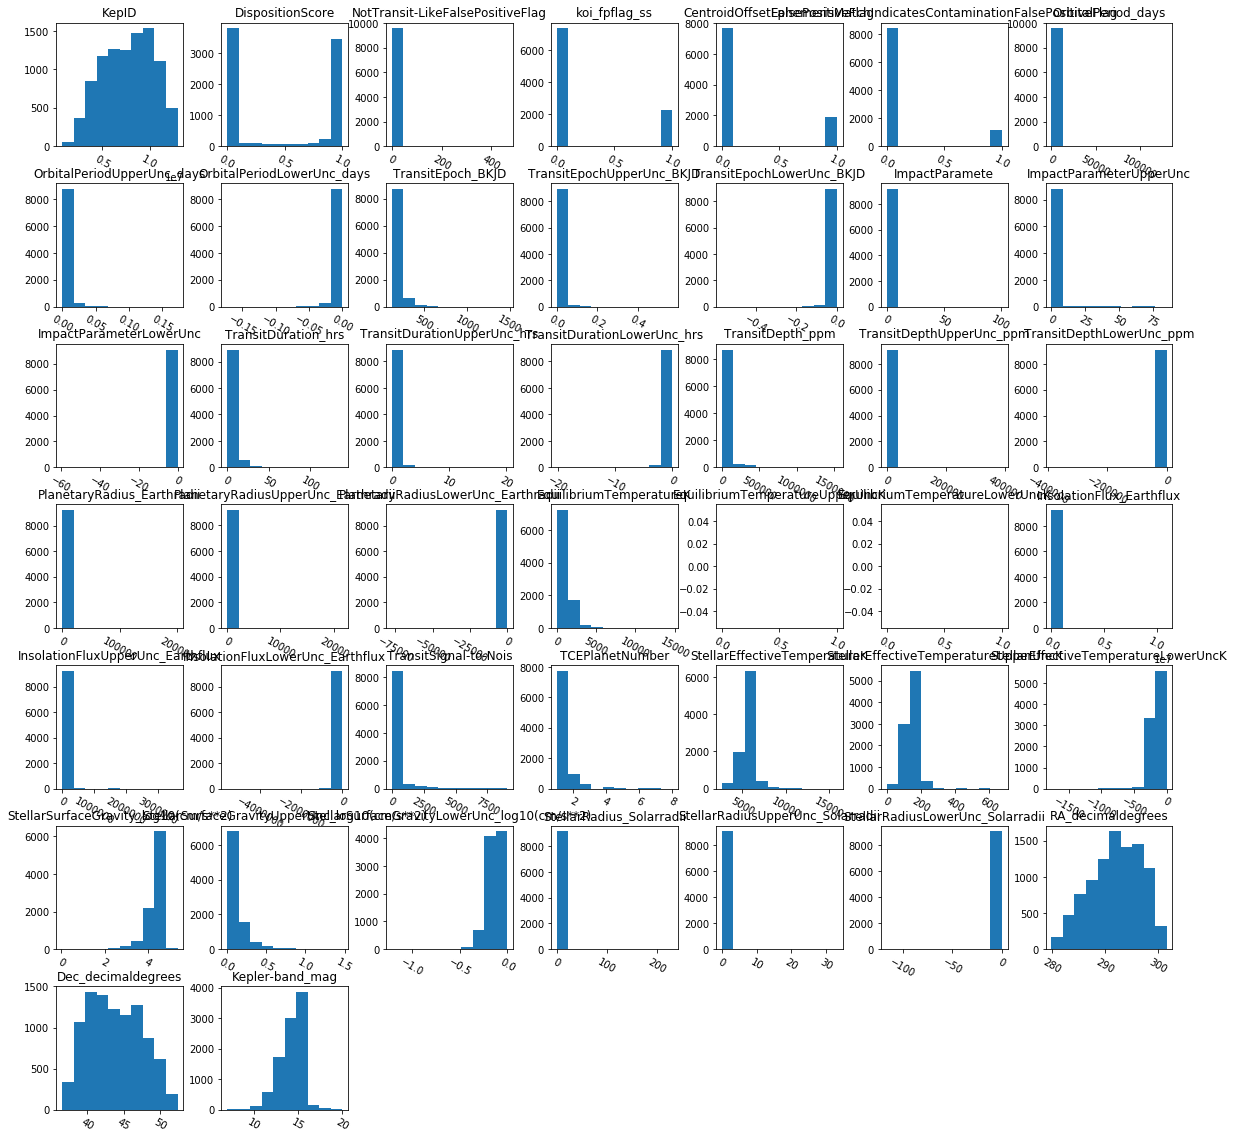

In [5]:
%matplotlib inline
# Plot histogram grid to check how data is distributed
df_nasa.hist(figsize=(20,20), xrot=-30, grid=False), 
plt.show()

In [6]:
#Decribe the the columns to get a better understanding of the data
df_nasa.describe()

,KepID,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod_days,OrbitalPeriodUpperUnc_days,OrbitalPeriodLowerUnc_days,TransitEpoch_BKJD,...,StellarEffectiveTemperatureLowerUncK,StellarSurfaceGravity_log10(cm/s**2),StellarSurfaceGravityUpperUnc_log10(cm/s**2),StellarSurfaceGravityLowerUnc_log10(cm/s**2),StellarRadius_Solarradii,StellarRadiusUpperUnc_Solarradii,StellarRadiusLowerUnc_Solarradii,RA_decimaldegrees,Dec_decimaldegrees,Kepler-band_mag
count,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,9564.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,7.690628e+06,0.480829,0.208595,0.232748,0.197512,0.120033,75.671358,0.002148,-0.002148,166.183251,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2.653459e+06,0.476928,4.767290,0.422605,0.398142,0.325018,1334.744046,0.008243,0.008243,67.918960,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.173000,120.515914,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,132.761718,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,137.224595,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,170.694603,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,1.293514e+07,1.000000,465.000000,1.000000,1.000000,1.000000,129995.778400,0.173000,0.000000,1472.522306,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


We have two options for the target variable ExoplanetArchiveDisposition and DispositionUsingKeplerData check dirstribution of the two of them

In [7]:
# Print the unique classes and their counts/frequencies
df_nasa['ExoplanetArchiveDisposition'].value_counts()

FALSE POSITIVE    4840
CANDIDATE         2367
CONFIRMED         2357
Name: ExoplanetArchiveDisposition, dtype: int64

In [8]:
# Print the unique classes and their counts/frequencies
df_nasa['DispositionUsingKeplerData'].value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: DispositionUsingKeplerData, dtype: int64

As the ExoplanetArchiveDisposition is using some archive knowledge we dont have access to and our goal is to predict based on  the kepler data we will choose DispositionUsingKeplerData as our target variable

We will have a binary classification problem <br>
The data is evenly distrobuted between candidate and False positive so no resampling necessary

We will make candidate class 1 and not candidate class 0

In [9]:
#make the target variable binary 
df_nasa['ExoplanetCandidate'] = df_nasa['DispositionUsingKeplerData'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)

# Data Cleaning

drop columns that can not be used for predicitons
(DispositionUsingKeplerData can be dropped as it was tranformed to binary in the column ExoplanetCandidate) 

In [10]:
#drop for prediction useless columns (names, etc)
df_nasa.drop(columns=['KepID','KOIName','KeplerName', \
                    'ExoplanetArchiveDisposition','TCEDeliver',\
                    'TCEPlanetNumber','DispositionUsingKeplerData',
                     'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss',
                     'CentroidOffsetFalsePositiveFlag','EphemerisMatchIndicatesContaminationFalsePositiveFlag'], inplace=True)

# Missing values

Check how many missing values each column contains

In [11]:
#Number of null values in the columns
df_nasa.isnull().sum()

DispositionScore                                1510
OrbitalPeriod_days                                 0
OrbitalPeriodUpperUnc_days                       454
OrbitalPeriodLowerUnc_days                       454
TransitEpoch_BKJD                                  0
TransitEpochUpperUnc_BKJD                        454
TransitEpochLowerUnc_BKJD                        454
ImpactParamete                                   363
ImpactParameterUpperUnc                          454
ImpactParameterLowerUnc                          454
TransitDuration_hrs                                0
TransitDurationUpperUnc_hrs                      454
TransitDurationLowerUnc_hrs                      454
TransitDepth_ppm                                 363
TransitDepthUpperUnc_ppm                         454
TransitDepthLowerUnc_ppm                         454
PlanetaryRadius_Earthradii                       363
PlanetaryRadiusUpperUnc_Earthradii               363
PlanetaryRadiusLowerUnc_Earthradii            

In [12]:
# Columns EquilibriumTemperatureUpperUncK and EquilibriumTemperatureLowerUncK contain only null values because of that drop them
df_nasa.drop(columns=['EquilibriumTemperatureUpperUncK','EquilibriumTemperatureLowerUncK'], inplace=True)

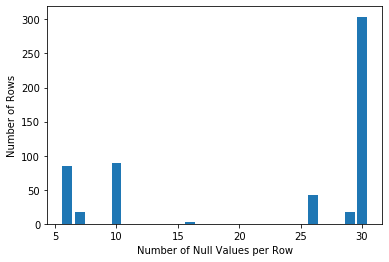

(9564, 37)


In [13]:
# For the other null values check for correlations in terms that there might be rows with multiple null values
null_counts = df_nasa.isnull().sum(axis=1)
null_values_row = null_counts.value_counts()
# plot number of rows and number of null values
null_values_row = null_values_row[(null_values_row.index != 0) & (null_values_row.index != 1)]
plt.bar(null_values_row.index, null_values_row.values)
# Add description to x-axis
plt.xlabel('Number of Null Values per Row')
# Add description to y-axis
plt.ylabel('Number of Rows')
plt.show()
print(df_nasa.shape)

we can see that we have rows with up to 30 null values as we are right now considering 41 columns we will drop all rows with 10 or more null values as around 25% of the values in those rows would need to be imputed so the gain in information with those rows is limited

In [14]:
# Filter the rows to keep only them with a null count less than 10
rows_to_keep = null_counts[null_counts < 10].index

#keep only those rows in the nasa dataset
df_nasa = df_nasa.loc[rows_to_keep]
#check how many rows are left
print(df_nasa.shape)

(9110, 37)


We dropped 454 out of 9564 rows so less than 5% of our data and still have 9110 rows left

In [15]:
#check the null count again after dropping the rows
df_nasa.isnull().sum()

DispositionScore                                1206
OrbitalPeriod_days                                 0
OrbitalPeriodUpperUnc_days                         0
OrbitalPeriodLowerUnc_days                         0
TransitEpoch_BKJD                                  0
TransitEpochUpperUnc_BKJD                          0
TransitEpochLowerUnc_BKJD                          0
ImpactParamete                                     0
ImpactParameterUpperUnc                            0
ImpactParameterLowerUnc                            0
TransitDuration_hrs                                0
TransitDurationUpperUnc_hrs                        0
TransitDurationLowerUnc_hrs                        0
TransitDepth_ppm                                   0
TransitDepthUpperUnc_ppm                           0
TransitDepthLowerUnc_ppm                           0
PlanetaryRadius_Earthradii                         0
PlanetaryRadiusUpperUnc_Earthradii                 0
PlanetaryRadiusLowerUnc_Earthradii            

We still have some columns with missing values those we will impute later after we have split the data into train and test set

# Correlation

checking if our features are correlated with each other

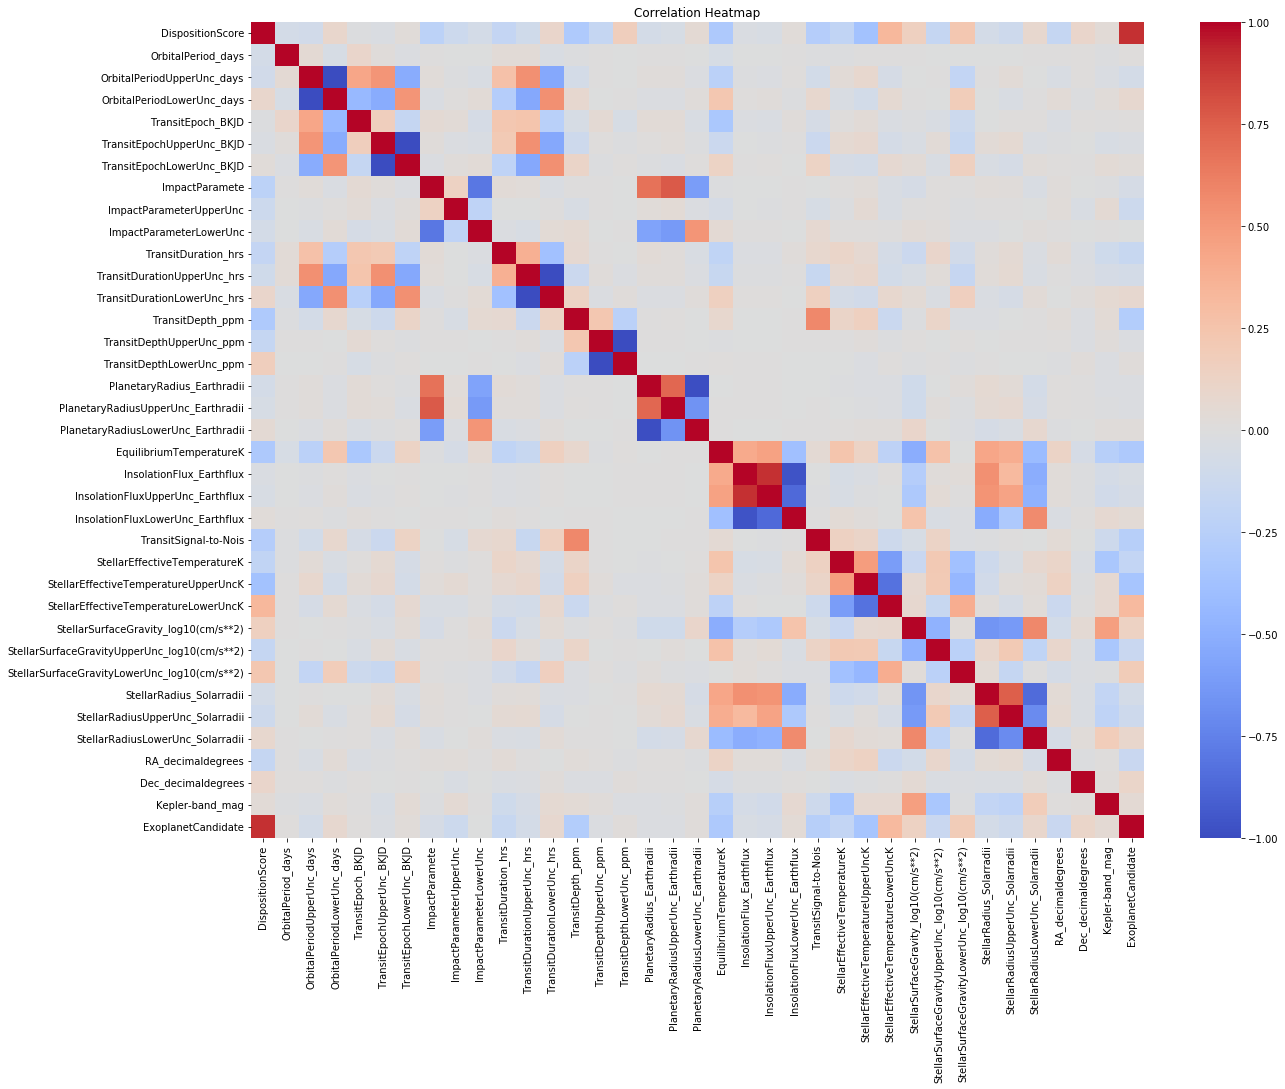

In [16]:
# Compute correlation matrix, include only float and int columns
#%matplotlib qt
%matplotlib inline
corr_matrix = df_nasa.select_dtypes(include=['float', 'int64']).corr()
plt.figure(figsize=(20, 15))
# Plot correlation heatmap
sn.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


disposition score has very strong correlation to our target variable (makes sense as it is not an observation but a computed value) so drop the disposition score

In [17]:
#drp disposition score
df_nasa.drop(columns=['DispositionScore'], inplace=True)

Additional observation: the uncertainties are always quite strong negatively correlated to each other because of that we will calculate the sum of them to have just a single uncertainty score (feature engineering). To be able to sum the values we first have to impute the missing values as some of the uncertainty columns have null values. For the imputation we first have to perform the train and test split.

# Split data in train and test

In [18]:
X = df_nasa.loc[:,df_nasa.columns != 'ExoplanetCandidate']
y = df_nasa['ExoplanetCandidate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Impute the missing values (seperatly for train and test)

performing knn-imputation for the columns with missing values

In [19]:
#impute the missing values with knn
def impute_missing_values(df):

    columns_with_missing_values = ['StellarEffectiveTemperatureLowerUncK','StellarEffectiveTemperatureUpperUncK', \
                                  'StellarSurfaceGravityUpperUnc_log10(cm/s**2)','StellarSurfaceGravityLowerUnc_log10(cm/s**2)',\
                                   'StellarSurfaceGravityLowerUnc_log10(cm/s**2)','StellarRadiusLowerUnc_Solarradii',\
                                    'StellarRadiusUpperUnc_Solarradii','Kepler-band_mag']
    imputer = KNNImputer(n_neighbors=3)
    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

    return df

In [20]:
#impute missing values in train and test data set
X_train = impute_missing_values(X_train)
X_test = impute_missing_values(X_test)

In [21]:
#check if all missing values were imputed
X_train.isnull().sum()

OrbitalPeriod_days                              0
OrbitalPeriodUpperUnc_days                      0
OrbitalPeriodLowerUnc_days                      0
TransitEpoch_BKJD                               0
TransitEpochUpperUnc_BKJD                       0
TransitEpochLowerUnc_BKJD                       0
ImpactParamete                                  0
ImpactParameterUpperUnc                         0
ImpactParameterLowerUnc                         0
TransitDuration_hrs                             0
TransitDurationUpperUnc_hrs                     0
TransitDurationLowerUnc_hrs                     0
TransitDepth_ppm                                0
TransitDepthUpperUnc_ppm                        0
TransitDepthLowerUnc_ppm                        0
PlanetaryRadius_Earthradii                      0
PlanetaryRadiusUpperUnc_Earthradii              0
PlanetaryRadiusLowerUnc_Earthradii              0
EquilibriumTemperatureK                         0
InsolationFlux_Earthflux                        0


In [22]:
X_test.isnull().sum()

OrbitalPeriod_days                              0
OrbitalPeriodUpperUnc_days                      0
OrbitalPeriodLowerUnc_days                      0
TransitEpoch_BKJD                               0
TransitEpochUpperUnc_BKJD                       0
TransitEpochLowerUnc_BKJD                       0
ImpactParamete                                  0
ImpactParameterUpperUnc                         0
ImpactParameterLowerUnc                         0
TransitDuration_hrs                             0
TransitDurationUpperUnc_hrs                     0
TransitDurationLowerUnc_hrs                     0
TransitDepth_ppm                                0
TransitDepthUpperUnc_ppm                        0
TransitDepthLowerUnc_ppm                        0
PlanetaryRadius_Earthradii                      0
PlanetaryRadiusUpperUnc_Earthradii              0
PlanetaryRadiusLowerUnc_Earthradii              0
EquilibriumTemperatureK                         0
InsolationFlux_Earthflux                        0


# Outliers 

Outlier detectuion and replacement using winsorization

In [23]:
# Set the thresholds for winsorization (meaning 5% lowest and 5% highest values are winsorized)
column_names_list = X_train.columns.tolist()
lower_threshold = 0.05
upper_threshold = 0.05

# Apply Winsorization to each column
winsorized_df = X_train.apply(lambda x: winsorize(x, limits=(lower_threshold, upper_threshold)))

# Update the original DataFrame with the winsorized values
X_train.update(winsorized_df)

X_train.head()

,OrbitalPeriod_days,OrbitalPeriodUpperUnc_days,OrbitalPeriodLowerUnc_days,TransitEpoch_BKJD,TransitEpochUpperUnc_BKJD,TransitEpochLowerUnc_BKJD,ImpactParamete,ImpactParameterUpperUnc,ImpactParameterLowerUnc,TransitDuration_hrs,...,StellarEffectiveTemperatureLowerUncK,StellarSurfaceGravity_log10(cm/s**2),StellarSurfaceGravityUpperUnc_log10(cm/s**2),StellarSurfaceGravityLowerUnc_log10(cm/s**2),StellarRadius_Solarradii,StellarRadiusUpperUnc_Solarradii,StellarRadiusLowerUnc_Solarradii,RA_decimaldegrees,Dec_decimaldegrees,Kepler-band_mag
5370,0.705174,3.460000e-07,-3.460000e-07,132.022402,0.000114,-0.000114,0.506,0.021,-0.018,1.93053,...,-157.0,4.612,0.052,-0.028,0.663,0.048,-0.058,294.35965,46.125389,15.911
3126,15.906889,2.550000e-05,-2.550000e-05,177.930500,0.001280,-0.001280,0.018,0.417,-0.014,3.98790,...,-101.0,4.554,0.036,-0.050,0.797,0.052,-0.042,290.29651,38.393131,14.172
4861,302.779824,9.590000e-03,-9.590000e-03,327.411200,0.026800,-0.026800,0.018,0.440,-0.005,16.10200,...,-154.0,4.572,0.042,-0.168,0.797,0.207,-0.069,295.98404,40.043621,14.160
5346,7.441344,1.630000e-04,-1.630000e-04,137.342900,0.017900,-0.017900,1.251,6.684,-0.518,2.87540,...,-252.0,4.321,0.105,-0.195,1.183,0.340,-0.183,287.37170,46.564838,14.114
8179,129.847318,5.350000e-03,-5.350000e-03,240.681200,0.024300,-0.024300,0.018,0.430,-0.005,13.05700,...,-257.0,4.427,0.072,-0.217,1.032,0.334,-0.119,293.67682,40.334068,14.520


# Feature Engineering

now we can combine the uncertainty features with the high negative correlations

In [24]:
#combine uncertainty features
def combine_uncertainties(df):
    
    #create new columns with the sum
    df['OrbitalPeriodUnc'] = abs(df['OrbitalPeriodUpperUnc_days']) + abs(df['OrbitalPeriodLowerUnc_days'])
    df['TransitEpochUnc'] = abs(df['TransitEpochUpperUnc_BKJD']) + abs(df['TransitEpochLowerUnc_BKJD'])
    df['ImpactParameterUnc'] = abs(df['ImpactParameterUpperUnc']) + abs(df['ImpactParameterLowerUnc'])
    df['TransitDurationUnc_hrs'] = abs(df['TransitDurationUpperUnc_hrs']) + abs(df['TransitDurationLowerUnc_hrs'])
    df['TransitDepthUnc_ppm'] = abs(df['TransitDepthUpperUnc_ppm']) + abs(df['TransitDepthLowerUnc_ppm'])
    df['PlanetaryRadiusUnc_Earthradii'] = abs(df['PlanetaryRadiusUpperUnc_Earthradii']) + abs(df['PlanetaryRadiusLowerUnc_Earthradii'])
    df['InsolationFluxUnc_Earthflux'] = abs(df['InsolationFluxUpperUnc_Earthflux']) + abs(df['InsolationFluxLowerUnc_Earthflux'])
    df['StellarEffectiveTemperatureUncK'] = abs(df['StellarEffectiveTemperatureUpperUncK']) + abs(df['StellarEffectiveTemperatureLowerUncK'])
    df['StellarSurfaceGravityUnc_log10(cm/s**2)'] = abs(df['StellarSurfaceGravityUpperUnc_log10(cm/s**2)']) + abs(df['StellarSurfaceGravityLowerUnc_log10(cm/s**2)'])
    df['StellarRadiusUnc_Solarradii'] = abs(df['StellarRadiusUpperUnc_Solarradii']) + abs(df['StellarRadiusLowerUnc_Solarradii'])
    
    #drop the old columns
    df.drop(columns=['OrbitalPeriodUpperUnc_days','OrbitalPeriodLowerUnc_days','TransitEpochUpperUnc_BKJD',\
                     'TransitEpochLowerUnc_BKJD','ImpactParameterUpperUnc','ImpactParameterLowerUnc',\
                     'TransitDurationUpperUnc_hrs','TransitDurationLowerUnc_hrs','TransitDepthUpperUnc_ppm',\
                     'TransitDepthLowerUnc_ppm','PlanetaryRadiusUpperUnc_Earthradii','PlanetaryRadiusLowerUnc_Earthradii',\
                     'InsolationFluxUpperUnc_Earthflux',\
                     'InsolationFluxLowerUnc_Earthflux','StellarEffectiveTemperatureUpperUncK',\
                     'StellarEffectiveTemperatureLowerUncK','StellarSurfaceGravityUpperUnc_log10(cm/s**2)',\
                     'StellarSurfaceGravityLowerUnc_log10(cm/s**2)','StellarRadiusUpperUnc_Solarradii',\
                     'StellarRadiusLowerUnc_Solarradii'], inplace=True)
    
    return df

In [25]:
#combine the uncertainties
X_train = combine_uncertainties(X_train)
X_test = combine_uncertainties(X_test)

# Scaling

As there is no clear gaussanity in all the features we are using the Min/Max Scaler

In [26]:
#apply Min/Max scaler
def scaling(X, y, scaler=None):    
    # scale only based on the training data set
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X= scaler.fit_transform(X)
    else: 
        X = scaler.transform(X) 

    return X, y, scaler

In [27]:
#Scale train and test data
X_train, y_train, scaler = scaling(X_train,y_train)
X_test, y_test, _ = scaling(X_test,y_test,scaler)

# Start testing different Models

in the following we will apply logistic regression, decison tree, random forrest and SVM models to our dataset

In [28]:
#create dataframe to safe the results of the models to compare them in the end
result_df = pd.DataFrame(columns=['Model','Details','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

#function to put cross validation result to our result dataframe
def append_results(model_name,details ,cross_val_results, result_df):
    # Calculate and store the average results over all iteration
    average_results = {
        'Model': model_name,
        'Details': details,
        'Accuracy': cross_val_results['test_accuracy'].mean(),
        'F1 Macro': cross_val_results['test_f1_macro'].mean(),
        'Precision Macro': cross_val_results['test_precision_macro'].mean(),
        'Recall Macro': cross_val_results['test_recall_macro'].mean()
    }
    
    # Append the average results to the result dataframe
    result_df = result_df.append(average_results, ignore_index=True)
    
    return result_df

# Logistic Regression

as we still have 25 features use regularized logistic regression to try to avoid over complex models

In [29]:
#regularized log regression
logreg = LogisticRegressionCV(Cs=10, random_state=1, cv = 5, scoring = 'accuracy',max_iter=5000)
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=5000, random_state=1, scoring='accuracy')

In [30]:
# print optimal regularization parameter 'C'
avg_crossval_scores = logreg.scores_[1].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

21.54434690031882


In [31]:
#print regression coefficients
logreg.coef_

array([[-2.09145305, -0.1744613 , -0.96781113, -0.72096287, -9.39261285,
        -6.06647004, -5.87842029, -1.01877919, -0.80194291,  2.1679141 ,
        -3.45556392, -0.24651949, -0.70512551,  0.79616408,  1.41034958,
         0.75683502, -0.20079409, -0.81050781, -2.5470872 , -0.16269737,
         3.57268358,  1.30299727, -2.76138184, -0.87388793, -1.26818403]])

In [32]:
#calculate regression results for best C
logreg = LogisticRegression(C=best_C,max_iter=5000)
cross_val_results = pd.DataFrame(cross_validate(logreg, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.206997,0.004996,0.837019,0.836624,0.839663,0.836765
1,0.205005,0.006000,0.830467,0.830430,0.830547,0.830403
2,0.117996,0.006999,0.829648,0.829622,0.829682,0.829602
3,0.159001,0.003999,0.828689,0.828314,0.830902,0.828418
4,0.172999,0.004999,0.832787,0.832528,0.834290,0.832565


Overall stable results but some regression coefficients are quite small and we needed to raise the max iterations for the logistic regression to be able to reach convergence: Because of that try feature selection to check if we can obtain a simpler model

# Feature Selection

perform backward feature selection so iteratively reduce number of features by removing the one with the least gain

In [33]:
#us logistis regression with the in the previous step optimized hyperparameter 'C'
logreg = LogisticRegression(C=best_C,max_iter=5000)

# Sequential Backward Selection
sbs = SFS(logreg, 
          forward=False, 
          floating=False,
          k_features=1,
          cv = 3,
          scoring='accuracy')
# Perform feature selection
sbs = sbs.fit(X_train, y_train)

In [34]:
df_log_reg_result = pd.DataFrame(sbs.get_metric_dict())
display(df_log_reg_result)

,25,24,23,22,21,20,19,18,17,16,...,10,9,8,7,6,5,4,3,2,1
feature_idx,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 17, ...","(0, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 17, 18, ...",...,"(0, 3, 4, 5, 6, 9, 10, 13, 18, 22)","(0, 3, 5, 6, 9, 10, 13, 18, 22)","(0, 3, 5, 6, 9, 10, 18, 22)","(3, 5, 6, 9, 10, 18, 22)","(3, 5, 6, 10, 18, 22)","(3, 5, 6, 10, 18)","(5, 6, 10, 18)","(5, 6, 18)","(5, 6)","(5,)"
cv_scores,"[0.8339066339066339, 0.8254670599803343, 0.829...","[0.8353808353808354, 0.8289085545722714, 0.832...","[0.8358722358722359, 0.8289085545722714, 0.832...","[0.8358722358722359, 0.8313667649950836, 0.832...","[0.8348894348894349, 0.8328416912487709, 0.831...","[0.8358722358722359, 0.8328416912487709, 0.831...","[0.8358722358722359, 0.8333333333333334, 0.830...","[0.8353808353808354, 0.8333333333333334, 0.830...","[0.8348894348894349, 0.8328416912487709, 0.831...","[0.8329238329238329, 0.831858407079646, 0.8318...",...,"[0.8162162162162162, 0.823992133726647, 0.8303...","[0.8176904176904177, 0.8200589970501475, 0.827...","[0.8211302211302212, 0.8190757128810227, 0.826...","[0.8147420147420148, 0.823992133726647, 0.8200...","[0.8152334152334152, 0.8146509341199607, 0.822...","[0.8034398034398035, 0.8249754178957719, 0.822...","[0.7936117936117936, 0.8210422812192724, 0.822...","[0.7837837837837838, 0.7964601769911505, 0.811...","[0.7759213759213759, 0.7831858407079646, 0.775...","[0.7154791154791155, 0.711897738446411, 0.7227..."
avg_score,0.829755,0.832213,0.832541,0.833196,0.833033,0.833524,0.83336,0.833196,0.833033,0.832214,...,0.823531,0.821728,0.822219,0.819598,0.817303,0.816977,0.812227,0.797315,0.778306,0.716697
feature_names,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...","(0, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 17, ...","(0, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 17, 18, ...",...,"(0, 3, 4, 5, 6, 9, 10, 13, 18, 22)","(0, 3, 5, 6, 9, 10, 13, 18, 22)","(0, 3, 5, 6, 9, 10, 18, 22)","(3, 5, 6, 9, 10, 18, 22)","(3, 5, 6, 10, 18, 22)","(3, 5, 6, 10, 18)","(5, 6, 10, 18)","(5, 6, 18)","(5, 6)","(5,)"
ci_bound,0.007756,0.00595,0.006415,0.004353,0.00325,0.003844,0.004591,0.004145,0.00325,0.00113,...,0.013036,0.009337,0.006993,0.00853,0.007533,0.02166,0.029634,0.025683,0.007765,0.010124
std_dev,0.003447,0.002644,0.002851,0.001934,0.001444,0.001708,0.00204,0.001842,0.001444,0.000502,...,0.005793,0.004149,0.003108,0.00379,0.003348,0.009625,0.013169,0.011413,0.003451,0.004499
std_err,0.002437,0.00187,0.002016,0.001368,0.001021,0.001208,0.001443,0.001302,0.001021,0.000355,...,0.004096,0.002934,0.002197,0.00268,0.002367,0.006806,0.009312,0.00807,0.00244,0.003181


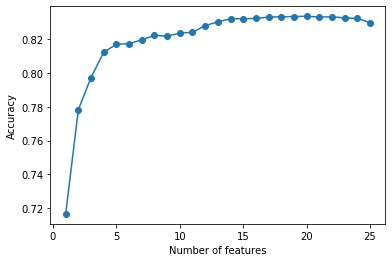

In [35]:
avg_score = df_log_reg_result.loc['avg_score']
ax = avg_score.plot(kind='line', marker='o')
# Add x-axis label
ax.set_xlabel('Number of features')
# Add y-axis label
ax.set_ylabel('Accuracy')
plt.show()

In [36]:
#print all the avergae accuracy
for column in df_log_reg_result.columns:
    avg_score = df_log_reg_result.loc['avg_score', column]
    # Access each column using the column label
    print(f"Number of Feutures '{column}': -> Accuracy {avg_score}" )

Number of Feutures '25': -> Accuracy 0.8297551775427882
Number of Feutures '24': -> Accuracy 0.8322131463724384
Number of Feutures '23': -> Accuracy 0.8325408272310928
Number of Feutures '22': -> Accuracy 0.8331963500105092
Number of Feutures '21': -> Accuracy 0.8330326303777632
Number of Feutures '20': -> Accuracy 0.8335241114002176
Number of Feutures '19': -> Accuracy 0.8333602307053635
Number of Feutures '18': -> Accuracy 0.8331964305415633
Number of Feutures '17': -> Accuracy 0.8330326303777632
Number of Feutures '16': -> Accuracy 0.8322135490277084
Number of Feutures '15': -> Accuracy 0.8320495878018002
Number of Feutures '14': -> Accuracy 0.8320495072707462
Number of Feutures '13': -> Accuracy 0.8302474638757825
Number of Feutures '12': -> Accuracy 0.8279539394583643
Number of Feutures '11': -> Accuracy 0.8240216886234585
Number of Feutures '10': -> Accuracy 0.8235306102562739
Number of Feutures '9': -> Accuracy 0.8217276810197164
Number of Feutures '8': -> Accuracy 0.82221875938

We can see convergence around 13 features so with only 13 features we are able to achieve a similar accuracy as with 25 features but we will have a simpler model

Select the top 10 features and perform the logistic regression again only with them

In [37]:
#function to only select the given number of features
def select_features(numpy_array,column_labels,feature_list):
    #covert numpy array to pandas dataframe to be able to select features by index
    df = pd.DataFrame(numpy_array, columns=column_labels)
    df = df.iloc[:, feature_list]
    return df

In [38]:
#gove dataframe the correct column labels to be able to print the names of the most important features
column_labels = ['OrbitalPeriod_days',
 'TransitEpoch_BKJD',
 'ImpactParamete',
 'TransitDuration_hrs',
 'TransitDepth_ppm',
 'PlanetaryRadius_Earthradii',
 'EquilibriumTemperatureK',
 'InsolationFlux_Earthflux',
 'TransitSignal-to-Nois',
 'StellarEffectiveTemperatureK',
 'StellarSurfaceGravity_log10(cm/s**2)',
 'StellarRadius_Solarradii',
 'RA_decimaldegrees',
 'Dec_decimaldegrees',
 'Kepler-band_mag',
 'OrbitalPeriodUnc',
 'TransitEpochUnc',
 'ImpactParameterUnc',
 'TransitDurationUnc_hrs',
 'TransitDepthUnc_ppm',
 'PlanetaryRadiusUnc_Earthradii',
 'InsolationFluxUnc_Earthflux',
 'StellarEffectiveTemperatureUncK',
 'StellarSurfaceGravityUnc_log10(cm/s**2)',
 'StellarRadiusUnc_Solarradii']

#Select the indexes of the 10 most important features and create a test and train data set only with them
feature_indexes = list(df_log_reg_result[13]['feature_idx'])
df_X_train = select_features(X_train,column_labels,feature_indexes)
df_X_test = select_features(X_test,column_labels,feature_indexes)

#print the feature names of the 10 most imprtant features
print(df_X_train.columns)

Index(['OrbitalPeriod_days', 'TransitDuration_hrs', 'TransitDepth_ppm',
       'PlanetaryRadius_Earthradii', 'EquilibriumTemperatureK',
       'StellarEffectiveTemperatureK', 'StellarSurfaceGravity_log10(cm/s**2)',
       'RA_decimaldegrees', 'Dec_decimaldegrees', 'Kepler-band_mag',
       'ImpactParameterUnc', 'TransitDurationUnc_hrs',
       'StellarEffectiveTemperatureUncK'],
      dtype='object')


In [39]:
#transform back to numpy array for logistic regression 
X_test_feature =  df_X_test.to_numpy()
X_train_feature = df_X_train.to_numpy()

#perform regularized logistic regression again to check if the optimal 'C' has changed for the selected features
logreg = LogisticRegressionCV(Cs=10, random_state=1, cv = 5, scoring = 'accuracy')
logreg.fit(X_train_feature, y_train)

LogisticRegressionCV(cv=5, random_state=1, scoring='accuracy')

In [40]:
#print te best C
avg_crossval_scores = logreg.scores_[1].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

21.54434690031882


In [41]:
#print the regression coefficients
logreg.coef_

array([[ -1.66344554,  -0.79856873, -11.60878082,  -4.02524782,
         -5.59942231,   2.00718278,  -2.09226242,  -0.70775296,
          0.77685463,   1.41807055,  -1.29567091,  -2.34724961,
         -3.05401075]])

In [42]:
#evaluate logistic regression for the best C and the selected set of features
logreg = LogisticRegression(C=best_C)
cross_val_results = pd.DataFrame(cross_validate(logreg, X_train_feature, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.120989,0.011001,0.830467,0.830029,0.833252,0.830203
1,0.063998,0.004999,0.826372,0.826274,0.826750,0.826242
2,0.047999,0.010003,0.833743,0.833707,0.833825,0.833679
3,0.212547,0.007000,0.827049,0.826526,0.830233,0.826725
4,0.047085,0.007992,0.834426,0.834101,0.836418,0.834172


Accuracy stayed similar but we did not need to higher the maximum iterations, the fit time is shorter and we have a less complex model

In [43]:
# put the result to the results dataframe
result_df = append_results('Logistic Regression','Feature Selection (13 features), hyperparameter C optimized', cross_val_results, result_df)

# Generalization
Apply the logistic regression model to the test data set to make predictions and see its generalization ability

In [44]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [45]:
logreg = LogisticRegression(C=best_C, max_iter = 2000)
y_pred = logreg.fit(X_train_feature, y_train).predict(X_test_feature)

confusion(y_test, pd.Series(y_pred))

predicted,0,1
target,,
0,1195,287
1,243,1282


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1482
           1       0.82      0.84      0.83      1525

    accuracy                           0.82      3007
   macro avg       0.82      0.82      0.82      3007
weighted avg       0.82      0.82      0.82      3007



Scores are similar to the scores of the cross validation of the training data set. So the model performs well on unseen data and is not overfitting.

# Decision Tree

In [47]:
#first check a "standard" decision tree with all features and without any optimized hyperparameters
model_tree = DecisionTreeClassifier()
cross_val_results = pd.DataFrame(cross_validate(model_tree, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.175993,0.005004,0.805897,0.805688,0.806822,0.805735
1,0.152036,0.004989,0.803440,0.803433,0.803430,0.803441
2,0.156033,0.009969,0.798526,0.798519,0.798516,0.798527
3,0.147108,0.006006,0.786885,0.786885,0.786945,0.786930
4,0.397549,0.004999,0.796721,0.796614,0.797052,0.796605


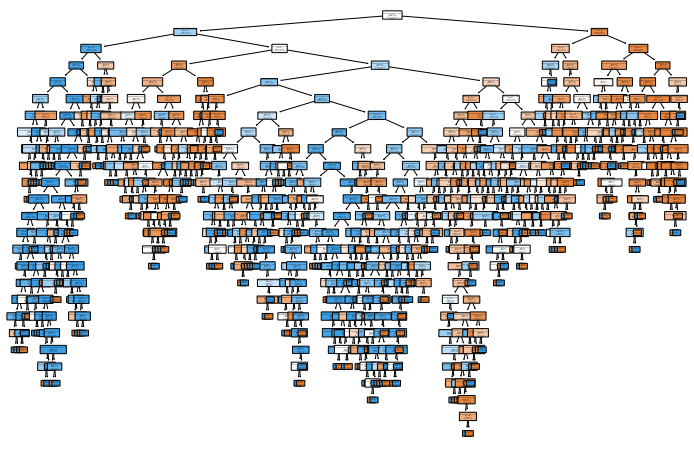

In [48]:
# Visualize the decision tree
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model_tree, filled=True, rounded=True, feature_names=[ 'OrbitalPeriod_days', 'TransitEpoch_BKJD', 'ImpactParamete', 'TransitDuration_hrs',
    'TransitDepth_ppm', 'PlanetaryRadius_Earthradii', 'EquilibriumTemperatureK',
    'InsolationFlux_Earthflux', 'TransitSignal-to-Nois', 'StellarEffectiveTemperatureK',
    'StellarSurfaceGravity_log10(cm/s**2)', 'StellarRadius_Solarradii', 'RA_decimaldegrees',
    'Dec_decimaldegrees', 'Kepler-band_mag', 'OrbitalPeriodUnc', 'TransitEpochUnc',
    'ImpactParameterUnc', 'TransitDurationUnc_hrs', 'TransitDepthUnc_ppm',
    'PlanetaryRadiusUnc_Earthradii', 'InsolationFluxUnc_Earthflux',
    'StellarEffectiveTemperatureUncK', 'StellarSurfaceGravityUnc_log10(cm/s**2)',
    'StellarRadiusUnc_Solarradii'], class_names=['no', 'yes'])
plt.show()

as the tree looks quite compley try to simplfy it be optimizing the max_depth of the tree

In [49]:
model_tree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_dephts = [None,2,4, 8, 12, 16, 20]

#perform grid search to optimize the hyperparameters
trc = GridSearchCV(estimator=model_tree,
                   scoring=['accuracy'],
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts
                   },
                   n_jobs=-1, 
                   cv=3,
                   refit='accuracy',
                   verbose=0)

grid_result = trc.fit(X_train, y_train)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

The best accuracy score for the training dataset is 0.8137
The best hyperparameters are {'criterion': 'entropy', 'max_depth': 4}


In [50]:
# Create Decision tree with optimal hyperparameters
model_tree_4 = DecisionTreeClassifier(criterion="entropy", max_depth=4)

#evaluate the model
cross_val_results = pd.DataFrame(cross_validate(model_tree_4, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.124998,0.007009,0.806716,0.806518,0.807589,0.806559
1,0.087013,0.008001,0.826372,0.826362,0.826362,0.826362
2,0.094000,0.007520,0.814906,0.814900,0.815087,0.814992
3,0.088536,0.005001,0.791803,0.791758,0.791882,0.791741
4,0.072040,0.004012,0.809016,0.808995,0.809348,0.809121


results are similar but tree is less complex because at max it will have 4 levels

In [51]:
# put to results dataframe
result_df = append_results('Decision Tree','Optimized hyperparameters criterion (entropy) and max_depth (4)', cross_val_results, result_df)

# Generalization

check how well the decision tree performs on the test data set

In [52]:
# Create Decision Tree model with the optimized hyperparameters from the previous step
model_tree_4 = DecisionTreeClassifier(criterion="entropy", max_depth=4)
#predict classes for X_test
y_pred = model_tree_4.fit(X_train, y_train).predict(X_test)

confusion(y_test, pd.Series(y_pred))

predicted,0,1
target,,
0,1199,283
1,270,1255


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1482
           1       0.82      0.82      0.82      1525

    accuracy                           0.82      3007
   macro avg       0.82      0.82      0.82      3007
weighted avg       0.82      0.82      0.82      3007



Scores are similar to the scores of the cross validation of the training data set. So the model performs well on unseen data and is not overfitting.

# Random Forest

In [54]:
# Instantiate the random forest classifier (without hyperparameter tuning )
ran_forest = RandomForestClassifier()

cross_val_results = pd.DataFrame(cross_validate(ran_forest, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,2.073556,0.045001,0.854218,0.854136,0.854717,0.854110
1,2.025671,0.037997,0.859951,0.859866,0.861313,0.860179
2,1.985250,0.037024,0.843571,0.843476,0.844880,0.843798
3,2.012001,0.042005,0.859836,0.859828,0.859833,0.859825
4,2.103577,0.086024,0.850820,0.850780,0.850975,0.850749


In [56]:
#!!! code takes around 5 minutes to complete the tuning !!!

#with hyperparameter tuning 
ran_forest = RandomForestClassifier()

ntrees = [100,200,300,None]
max_depth = [50, 100,200,None]
criterion = ['gini', 'entropy']

#perform grid search to tune the hyperparameters
trc = GridSearchCV(estimator=ran_forest,
                   scoring=['accuracy'],
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'criterion':criterion
                   },
                   n_jobs=-1, 
                   cv=3,
                   refit='accuracy',
                   verbose=0)

grid_result = trc.fit(X_train, y_train)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py", line 133, in _validate_estimator
    type(self.n_estimators)
ValueError: n_estimators must be an integ

The best accuracy score for the training dataset is 0.8538
The best hyperparameters are {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}


In [57]:
# Instantiate the random forest classifier with the tuned hyperparameters
ran_forest = RandomForestClassifier(criterion = 'entropy' , max_depth = None, n_estimators = 100)
#evaluate results
cross_val_results = pd.DataFrame(cross_validate(ran_forest, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,2.755359,0.036946,0.857494,0.857402,0.858091,0.857376
1,2.829297,0.037039,0.855856,0.855821,0.856526,0.856017
2,2.803964,0.036051,0.852580,0.852544,0.853245,0.852741
3,2.593990,0.036010,0.855738,0.855728,0.855740,0.855721
4,3.245946,0.050009,0.844262,0.844212,0.844465,0.844180


In [58]:
#put to results dataframe
result_df = append_results('Random Forest','Optimized hyperparameters criterion, max_depth and n_estimators', cross_val_results, result_df)

# Generalization

check how the random forest performs on the test datatset 

In [59]:
# create random forest with the optimal hyperparameters
ran_forest = RandomForestClassifier(criterion = 'entropy' , max_depth = None, n_estimators = 100)
# get predictions
y_pred = ran_forest.fit(X_train, y_train).predict(X_test)

confusion(y_test, pd.Series(y_pred))

predicted,0,1
target,,
0,1252,230
1,222,1303


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1482
           1       0.85      0.85      0.85      1525

    accuracy                           0.85      3007
   macro avg       0.85      0.85      0.85      3007
weighted avg       0.85      0.85      0.85      3007



Scores are similar to the scores of the cross validation of the training data set. So the model performs well on unseen data and is not overfitting.

# SVM (support verctor machine)

optimize the regulariziation parameter 'C' and the type of kernel function

In [61]:
# List of C values
C_range = np.logspace(-2, 3, 6)
# Define the search space for grid search
param_grid = { 
    "C": C_range,
    "kernel": ['rbf', 'linear']
    }
scoring = ['accuracy']

In [62]:
#perform grid search to optimize the hyperparameters
svm = SVC()
grid_search = GridSearchCV(estimator=svm, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=0)

grid_result = grid_search.fit(X_train, y_train)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

The best accuracy score for the training dataset is 0.8460
The best hyperparameters are {'C': 1.0, 'kernel': 'rbf'}


In [63]:
#svm model with the found hyperparameters for best hyperparameters
svm = SVC(C=1.0,kernel='rbf')
cross_val_results = pd.DataFrame(cross_validate(svm, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.813166,0.328043,0.847666,0.847378,0.849733,0.847445
1,0.831546,0.317036,0.839476,0.839463,0.839475,0.839455
2,1.083960,0.501000,0.844390,0.844389,0.844401,0.844418
3,0.934287,0.327042,0.845902,0.845808,0.846391,0.845777
4,0.873104,0.343950,0.845082,0.844954,0.845808,0.844930


In [64]:
result_df = append_results('SVM','With feature  selection ', cross_val_results, result_df)

# Feature Selection

perform feature selection for support vector machine to check if as for logistic regression we can obtain a less complex model with same accuracy

In [65]:
#!!! Code for the backward feature selection takes around 15 minutes to finish !!! 

#perform feature slection for svm we will use the found hyperparameters from above 
svm = SVC(C=1.0,kernel='rbf')

# Sequential Backward Selection (same algorithm as for logistic regression)
sbs = SFS(svm, 
          forward=False, 
          floating=False,
          k_features=1,
          scoring='accuracy',
          cv = 3)

sbs = sbs.fit(X_train, y_train)

In [66]:
#display the results
df_svm_result = pd.DataFrame(sbs.get_metric_dict())
display(df_svm_result)

,25,24,23,22,21,20,19,18,17,16,...,10,9,8,7,6,5,4,3,2,1
feature_idx,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",...,"(0, 2, 3, 5, 6, 9, 10, 12, 18, 23)","(2, 3, 5, 6, 9, 10, 12, 18, 23)","(3, 5, 6, 9, 10, 12, 18, 23)","(3, 5, 6, 9, 10, 18, 23)","(3, 5, 6, 10, 18, 23)","(3, 5, 6, 10, 18)","(5, 6, 10, 18)","(5, 6, 18)","(5, 6)","(5,)"
cv_scores,"[0.8476658476658476, 0.839724680432645, 0.8505...","[0.8476658476658476, 0.8416912487708947, 0.850...","[0.8457002457002457, 0.8421828908554573, 0.852...","[0.8457002457002457, 0.8407079646017699, 0.853...","[0.8457002457002457, 0.8436578171091446, 0.852...","[0.8486486486486486, 0.8411996066863323, 0.853...","[0.8486486486486486, 0.8421828908554573, 0.853...","[0.8486486486486486, 0.8451327433628318, 0.854...","[0.8457002457002457, 0.8416912487708947, 0.855...","[0.8457002457002457, 0.8421828908554573, 0.854...",...,"[0.8373464373464373, 0.8387413962635202, 0.849...","[0.8314496314496315, 0.8407079646017699, 0.848...","[0.8255528255528255, 0.8357915437561455, 0.847...","[0.8221130221130221, 0.8333333333333334, 0.850...","[0.8176904176904177, 0.8323500491642084, 0.844...","[0.8088452088452088, 0.827433628318584, 0.8402...","[0.802948402948403, 0.8220255653883972, 0.8323...","[0.7936117936117936, 0.8146509341199607, 0.809...","[0.7754299754299754, 0.7930186823992134, 0.772...","[0.7213759213759213, 0.7168141592920354, 0.728..."
avg_score,0.845977,0.846469,0.846961,0.846797,0.847125,0.84778,0.848107,0.849418,0.84778,0.847616,...,0.841882,0.84008,0.836148,0.835329,0.831397,0.825498,0.819108,0.805999,0.780273,0.722104
feature_names,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",...,"(0, 2, 3, 5, 6, 9, 10, 12, 18, 23)","(2, 3, 5, 6, 9, 10, 12, 18, 23)","(3, 5, 6, 9, 10, 12, 18, 23)","(3, 5, 6, 9, 10, 18, 23)","(3, 5, 6, 10, 18, 23)","(3, 5, 6, 10, 18)","(5, 6, 10, 18)","(5, 6, 18)","(5, 6)","(5,)"
ci_bound,0.010294,0.007911,0.010137,0.012319,0.008006,0.011376,0.010424,0.008669,0.01351,0.012133,...,0.012281,0.015313,0.019803,0.026309,0.024355,0.028984,0.027407,0.020222,0.020475,0.010453
std_dev,0.004574,0.003516,0.004505,0.005474,0.003558,0.005055,0.004632,0.003852,0.006004,0.005392,...,0.005457,0.006805,0.0088,0.011691,0.010823,0.01288,0.012179,0.008986,0.009099,0.004645
std_err,0.003235,0.002486,0.003185,0.003871,0.002516,0.003575,0.003275,0.002724,0.004245,0.003812,...,0.003859,0.004812,0.006222,0.008267,0.007653,0.009108,0.008612,0.006354,0.006434,0.003285


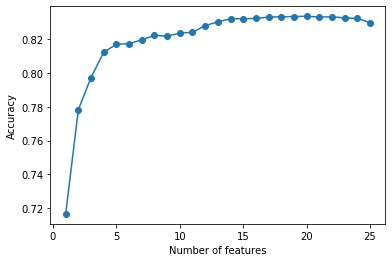

In [67]:
avg_score = df_log_reg_result.loc['avg_score']
ax = avg_score.plot(kind='line', marker='o')
# Add x-axis label
ax.set_xlabel('Number of features')
# Add y-axis label
ax.set_ylabel('Accuracy')
plt.show()

In [68]:
#print all the avergae accuracy
for column in df_svm_result.columns:
    avg_score = df_svm_result.loc['avg_score', column]
    # Access each column using the column label
    print(f"Number of Feutures '{column}': -> Accuracy {avg_score}" )

Number of Feutures '25': -> Accuracy 0.8459771114638371
Number of Feutures '24': -> Accuracy 0.8464687535483995
Number of Feutures '23': -> Accuracy 0.846960717757178
Number of Feutures '22': -> Accuracy 0.8467968370623238
Number of Feutures '21': -> Accuracy 0.847124598452032
Number of Feutures '20': -> Accuracy 0.8477796380451248
Number of Feutures '19': -> Accuracy 0.848107399434833
Number of Feutures '18': -> Accuracy 0.8494184449936663
Number of Feutures '17': -> Accuracy 0.8477801212314486
Number of Feutures '16': -> Accuracy 0.8476162405365946
Number of Feutures '15': -> Accuracy 0.8474522793106863
Number of Feutures '14': -> Accuracy 0.8471246789830861
Number of Feutures '13': -> Accuracy 0.8456502359157226
Number of Feutures '12': -> Accuracy 0.8454866773450843
Number of Feutures '11': -> Accuracy 0.8435206727242126
Number of Feutures '10': -> Accuracy 0.8418817852446171
Number of Feutures '9': -> Accuracy 0.8400800639738693
Number of Feutures '8': -> Accuracy 0.83614789367001

We can see convergence around 14 features so with only 14 features we are able to achieve a similar accuracy as with 25 features but we will have a simpler model

In [69]:
#Select the indexes of the 14 most important features and create a test and train data set only with them
feature_indexes = list(df_svm_result[14]['feature_idx'])
df_X_train = select_features(X_train,column_labels,feature_indexes)
df_X_test = select_features(X_test,column_labels,feature_indexes)

#print the feature names of the 14 most imprtant features
print(df_X_train.columns)

Index(['OrbitalPeriod_days', 'ImpactParamete', 'TransitDuration_hrs',
       'PlanetaryRadius_Earthradii', 'EquilibriumTemperatureK',
       'StellarEffectiveTemperatureK', 'StellarSurfaceGravity_log10(cm/s**2)',
       'StellarRadius_Solarradii', 'RA_decimaldegrees', 'Dec_decimaldegrees',
       'Kepler-band_mag', 'OrbitalPeriodUnc', 'TransitDurationUnc_hrs',
       'StellarSurfaceGravityUnc_log10(cm/s**2)'],
      dtype='object')


In [70]:
#transform back to numpy array for svm
X_test_feature =  df_X_test.to_numpy()
X_train_feature = df_X_train.to_numpy()
svc = SVC()

#perform grid search again to check if the optimal hyperparameters have changed for the selected features
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=0)

grid_result = grid_search.fit(X_train_feature, y_train)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

The best accuracy score for the training dataset is 0.8471
The best hyperparameters are {'C': 1.0, 'kernel': 'rbf'}


In [71]:
#evaluate SVM with the optimal hyperparameters and the result of the feature selection
svm = SVC(C=1.0,kernel='rbf')
cross_val_results = pd.DataFrame(cross_validate(svm, X_train_feature, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

cross_val_results

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.753878,0.342094,0.850123,0.849760,0.852880,0.849869
1,0.765058,0.324003,0.845209,0.845167,0.845338,0.845134
2,0.724183,0.312961,0.850942,0.850942,0.851004,0.850994
3,0.737208,0.335959,0.849180,0.848947,0.850769,0.848959
4,0.868772,0.423509,0.847541,0.847360,0.848690,0.847352


we get the same hyperparameters and similar accuracy but a simplar model as we are using less features

In [72]:
#put to results dataframe
result_df = append_results('SVM','performed feature selection (14 features) and hyperparameter optimization (kernel,C)', cross_val_results, result_df)

# Generalization

check how SVM model performs on the test datatset 

In [73]:
# create SVM with the optimal hyperparameters
svm = SVC(C=1.0,kernel='rbf')
# get predictions
y_pred = svm.fit(X_train, y_train).predict(X_test)

confusion(y_test, pd.Series(y_pred))

predicted,0,1
target,,
0,1240,242
1,228,1297


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1482
           1       0.84      0.85      0.85      1525

    accuracy                           0.84      3007
   macro avg       0.84      0.84      0.84      3007
weighted avg       0.84      0.84      0.84      3007



Scores are similar to the scores of the cross validation of the training data set. So the model performs well on unseen data and is not overfitting.

# Final result 

Check which model performed the best

In [75]:
result_df.sort_values(by='F1 Macro',ascending=False)

,Model,Details,Accuracy,F1 Macro,Precision Macro,Recall Macro
2,Random Forest,"Optimized hyperparameters criterion, max_depth...",0.853186,0.853141,0.853614,0.853207
4,SVM,performed feature selection (14 features) and ...,0.848599,0.848435,0.849736,0.848462
3,SVM,With feature selection,0.844503,0.844399,0.845162,0.844405
0,Logistic Regression,"Feature Selection (13 features), hyperparamete...",0.830411,0.830127,0.832096,0.830204
1,Decision Tree,Optimized hyperparameters criterion (entropy) ...,0.809763,0.809707,0.810054,0.809755


Random Forest performed the best and required now time consuming feature selection so we choose Random Forest as our final model

Apply Final model on the test data

In [76]:
# Generalization of best model (random forrest)
ran_forest = RandomForestClassifier(criterion = 'entropy' , max_depth = None, n_estimators = 100)
y_pred = ran_forest.fit(X_train, y_train).predict(X_test)

confusion(y_test, pd.Series(y_pred))

predicted,0,1
target,,
0,1251,231
1,228,1297


In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1482
           1       0.85      0.85      0.85      1525

    accuracy                           0.85      3007
   macro avg       0.85      0.85      0.85      3007
weighted avg       0.85      0.85      0.85      3007

